In [1]:
import pandas as pd
import rasterio
from rasterstats import zonal_stats
from osgeo import gdal
import geopandas as gpd
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
from shapely.geometry import Point
from shapely.geometry import Polygon
from pyproj import CRS
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pyproj

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [21]:
#merge tif files for nightlights 4-5-6
day_04 = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Nightlights/Isaias/Zonal_Day_04.csv")
day_05 = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Nightlights/Isaias/Zonal_Day_05.csv")
day_06 = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Nightlights/Isaias/Zonal_Day_06.csv")

In [22]:
day_04.head()

,id,left,top,right,bottom,_count,_sum,_mean
0,1,2054340,-81750,2054840,-82250,NaN,NaN,NaN
1,2,2054340,-82250,2054840,-82750,NaN,NaN,NaN
2,3,2054340,-82750,2054840,-83250,NaN,NaN,NaN
3,4,2054340,-83250,2054840,-83750,NaN,NaN,NaN
4,5,2054340,-83750,2054840,-84250,NaN,NaN,NaN


In [23]:
day_04.shape

(131610, 8)

In [24]:
day_04['_mean'].count()

0

In [25]:
day_05['_mean'].count()

20608

In [26]:
day_06['_mean'].count()

14039

In [27]:
# Merge the dataframes on the 'id' column
day_4_6 = pd.merge(day_04, day_05, on='id')
day_4_6 = pd.merge(day_4_6, day_06, on='id')

# Calculate the maximum mean value for each id
day_4_6['max_mean'] = day_4_6[['_mean_x', '_mean_y', '_mean']].max(axis=1)

# Drop the individual 'mean' columns
day_4_6 = day_4_6.drop(['_mean_x', '_mean_y', '_mean'], axis=1)

# Rename the 'max_mean' column to 'mean'
day_4_6 = day_4_6.rename(columns={'max_mean': 'mean'})
day_4_6 = day_4_6[["id","mean"]]

day_4_6.head()

,id,mean
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [28]:
day_4_6['mean'].count()

30346

In [29]:
wind = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Wind/Isaias_NJ_speed_backwinds_akshay_05302023.csv")
wind.head()

,ID,Center_Latitude,Center_Longitude,Distance,Vmax,Rmax
0,0,41.416894,-74.954401,303.584894,32.247100,120.546311
1,1,41.412650,-74.956148,303.889350,32.248157,120.546311
2,2,41.408405,-74.957895,304.193811,32.249218,120.546311
3,3,41.404161,-74.959642,304.498275,32.313243,120.546311
4,4,41.399917,-74.961389,304.802744,32.314315,120.546311


In [35]:
wind = wind[["ID","Vmax"]]
wind.head()

,ID,Vmax
0,0,32.247100
1,1,32.248157
2,2,32.249218
3,3,32.313243
4,4,32.314315


In [30]:
landcover_zonal = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Landcover/zonal_500.csv")
histo_columns = ['HISTO_0', 'HISTO_1', 'HISTO_5', 'HISTO_6', 'HISTO_8', 'HISTO_10',
                 'HISTO_14', 'HISTO_15', 'HISTO_16', 'HISTO_17', 'HISTO_18', 'HISTO_NODATA']

# Convert HISTO columns to percentages
landcover_zonal[histo_columns] = landcover_zonal[histo_columns].div(landcover_zonal[histo_columns].sum(axis=1), axis=0) * 100
landcover_zonal.head()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA
0,1,2054340,-81750,2054840,-82250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
1,2,2054340,-82250,2054840,-82750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
2,3,2054340,-82750,2054840,-83250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
3,4,2054340,-83250,2054840,-83750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
4,5,2054340,-83750,2054840,-84250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0


In [19]:
landcover_zonal.shape

(131610, 17)

In [32]:
landcover_zonal.describe()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA
count,131610.000000,1.316100e+05,131610.000000,1.316100e+05,131610.000000,131610.000000,131610.000000,131610.000000,131610.000000,131610.000000,131610.000000,131610.000000,131610.000000,131610.000000,131610.000000,131610.000000,131610.000000
mean,65805.500000,2.115590e+06,-215250.000000,2.116090e+06,-215750.000000,0.214279,2.389759,11.657504,3.058500,0.354946,0.388367,12.890164,7.908759,0.244539,19.122997,1.336789,40.433398
std,37992.678801,3.550688e+04,77220.756979,3.550688e+04,77220.756979,3.139494,11.042185,22.794846,9.332954,2.039667,3.188417,24.735643,19.692053,2.852500,31.297314,7.215844,48.668426
min,1.000000,2.054340e+06,-348750.000000,2.054840e+06,-349250.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32903.250000,2.084840e+06,-282250.000000,2.085340e+06,-282750.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65805.500000,2.115590e+06,-215250.000000,2.116090e+06,-215750.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,98707.750000,2.146340e+06,-148250.000000,2.146840e+06,-148750.000000,0.000000,0.000000,11.072664,0.000000,0.000000,0.000000,12.867647,0.346021,0.000000,23.529412,0.000000,100.000000
max,131610.000000,2.176840e+06,-81750.000000,2.177340e+06,-82250.000000,100.000000,100.000000,100.000000,96.885813,84.191176,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [34]:
landcover_zonal[landcover_zonal["HISTO_17"]>0].shape

(61240, 17)

In [36]:
rainfall = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Rainfall/Isaias/rainfall_day4.csv")
rainfall.head()

,Unnamed: 0,Center_Latitude,Center_Longitude,Rainfall
0,0,41.416894,-74.954401,17.378107
1,1,41.412650,-74.956148,17.378107
2,2,41.408405,-74.957895,17.378107
3,3,41.404161,-74.959642,17.378107
4,4,41.399917,-74.961389,17.378107


In [48]:
rainfall = rainfall.rename(columns={'Unnamed: 0': 'id'})

In [74]:
night_month = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Nightlights_Monthly/Zonal_July_Monthly.csv")
night_month.head()

,id,left,top,right,bottom,_count,_sum,_mean
0,1,2054340,-81750,2054840,-82250,NaN,NaN,NaN
1,2,2054340,-82250,2054840,-82750,NaN,NaN,NaN
2,3,2054340,-82750,2054840,-83250,NaN,NaN,NaN
3,4,2054340,-83250,2054840,-83750,NaN,NaN,NaN
4,5,2054340,-83750,2054840,-84250,NaN,NaN,NaN


In [75]:
night_month.shape

(131610, 8)

In [76]:
night_month['_mean'].count()

80509

In [77]:
night_month = night_month.rename(columns={'_mean': 'nightlight_prev'})
night_month = night_month[["id","nightlight_prev"]]
night_month.head()

,id,nightlight_prev
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [42]:
landcover_zonal.head()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA
0,1,2054340,-81750,2054840,-82250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
1,2,2054340,-82250,2054840,-82750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
2,3,2054340,-82750,2054840,-83250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
3,4,2054340,-83250,2054840,-83750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
4,5,2054340,-83750,2054840,-84250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0


In [43]:
wind.head()

,ID,Vmax
0,0,32.247100
1,1,32.248157
2,2,32.249218
3,3,32.313243
4,4,32.314315


In [45]:
day_4_6.head()

,id,mean
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [59]:
day_4_6=day_4_6.dropna()

In [60]:
day_4_6.shape

(30346, 2)

In [78]:
regression_df = landcover_zonal.merge(wind,how="left", left_on="id",right_on="ID").fillna(0)
regression_df = regression_df.merge(day_4_6,how="inner",on="id")
regression_df = regression_df.merge(night_month,how="inner",on="id")
regression_df = regression_df.merge(rainfall,how="inner",on="id")
regression_df.head()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA,ID,Vmax,mean,nightlight_prev,Center_Latitude,Center_Longitude,Rainfall
0,99,2054340,-130750,2054840,-131250,0.0,0.0,0.346021,3.114187,0.0,0.0,0.0,0.0,0.0,0.346021,13.840830,82.352941,99.0,35.716262,1.400000,0.662775,40.996445,-75.125785,43.50561
1,100,2054340,-131250,2054840,-131750,0.0,0.0,41.522491,4.152249,0.0,0.0,0.0,0.0,0.0,8.304498,22.491349,23.529412,100.0,35.810302,1.400000,0.848879,40.992195,-75.127499,43.50561
2,101,2054340,-131750,2054840,-132250,0.0,0.0,67.279412,0.000000,0.0,0.0,0.0,0.0,0.0,7.352941,13.602941,11.764706,101.0,35.812064,0.900000,1.150000,40.987946,-75.129214,43.50561
3,102,2054340,-132250,2054840,-132750,0.0,0.0,39.446367,0.000000,0.0,0.0,0.0,0.0,0.0,13.148789,13.494810,33.910035,102.0,35.813835,5.401564,2.905872,40.983696,-75.130928,43.50561
4,103,2054340,-132750,2054840,-133250,0.0,0.0,31.833910,7.958478,0.0,0.0,0.0,0.0,0.0,13.494810,12.802768,33.910035,103.0,35.815615,8.231423,3.000000,40.979446,-75.132641,43.50561


In [79]:
regression_df = regression_df.drop(['id', 'left', 'top', 'right', 'bottom','ID','Center_Latitude',
                                    'Center_Longitude','HISTO_NODATA'], axis=1)
regression_df.shape

(30346, 15)

In [80]:
regression_df.columns

Index(['HISTO_0', 'HISTO_1', 'HISTO_5', 'HISTO_6', 'HISTO_8', 'HISTO_10',
       'HISTO_14', 'HISTO_15', 'HISTO_16', 'HISTO_17', 'HISTO_18', 'Vmax',
       'mean', 'nightlight_prev', 'Rainfall'],
      dtype='object')

In [81]:
#remove rows with no urban
#only keep rows with values for target column

regression_df = regression_df[regression_df["HISTO_17"]>0]
regression_df.shape

(20834, 15)

In [82]:
regression_df.describe()

,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,Vmax,mean,nightlight_prev,Rainfall
count,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000
mean,0.178764,3.874497,20.664907,5.281671,0.588826,0.701189,17.031790,10.551053,0.585952,35.963069,2.144496,42.398532,5.641572,6.058875,42.814363
std,1.820373,13.396157,26.593611,10.909021,2.853406,3.946704,24.131529,20.546916,3.983773,33.136456,8.274914,5.246248,10.385457,12.394678,28.475728
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.346021,0.000000,32.978846,0.000000,0.000000,2.485539
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.593750,0.000000,37.022685,0.324162,0.597891,14.240076
50%,0.000000,0.000000,7.148843,0.000000,0.000000,0.000000,5.190311,0.000000,0.000000,20.761246,0.000000,44.524185,1.695010,2.000000,39.483420
75%,0.000000,0.000000,34.948097,5.190311,0.000000,0.000000,25.367647,9.765625,0.000000,62.975779,0.000000,46.419673,6.853343,7.286298,66.096980
max,60.294118,99.218750,99.653979,93.750000,84.191176,97.231834,99.653979,99.609375,87.132353,100.000000,99.307958,49.790469,276.450000,442.900000,102.050370


### Machine Learning Models

#### Linear Regression

In [83]:
regression_df.describe()

,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,Vmax,mean,nightlight_prev,Rainfall
count,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000,20834.000000
mean,0.178764,3.874497,20.664907,5.281671,0.588826,0.701189,17.031790,10.551053,0.585952,35.963069,2.144496,42.398532,5.641572,6.058875,42.814363
std,1.820373,13.396157,26.593611,10.909021,2.853406,3.946704,24.131529,20.546916,3.983773,33.136456,8.274914,5.246248,10.385457,12.394678,28.475728
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.346021,0.000000,32.978846,0.000000,0.000000,2.485539
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.593750,0.000000,37.022685,0.324162,0.597891,14.240076
50%,0.000000,0.000000,7.148843,0.000000,0.000000,0.000000,5.190311,0.000000,0.000000,20.761246,0.000000,44.524185,1.695010,2.000000,39.483420
75%,0.000000,0.000000,34.948097,5.190311,0.000000,0.000000,25.367647,9.765625,0.000000,62.975779,0.000000,46.419673,6.853343,7.286298,66.096980
max,60.294118,99.218750,99.653979,93.750000,84.191176,97.231834,99.653979,99.609375,87.132353,100.000000,99.307958,49.790469,276.450000,442.900000,102.050370


In [84]:
nan_count = regression_df.isna().sum()
print(nan_count)

HISTO_0            0
HISTO_1            0
HISTO_5            0
HISTO_6            0
HISTO_8            0
HISTO_10           0
HISTO_14           0
HISTO_15           0
HISTO_16           0
HISTO_17           0
HISTO_18           0
Vmax               0
mean               0
nightlight_prev    0
Rainfall           0
dtype: int64


In [85]:
df = regression_df.copy()

#df = df.drop("HISTO_NODATA", axis=1)

# Separate independent and dependent variables
X = df.drop('mean', axis=1)  # Independent variables
y = df['mean']  # Dependent variable

# Standardize independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and fit the regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Print the model coefficients
print("Model Coefficients:")
for feature, coef in zip(X.columns, reg_model.coef_):
    print(feature, ":", coef)

# Predict on the test set
y_pred = reg_model.predict(X_test)

# Calculate R2 score on the test set
r2 = r2_score(y_test, y_pred)

# Print the R2 score
print("R2 score on the test set:", r2)

Model Coefficients:
HISTO_0 : 0.01320116557268887
HISTO_1 : -0.22925088320258102
HISTO_5 : -0.5049285118210731
HISTO_6 : -0.21711953260182143
HISTO_8 : -0.08700506415389063
HISTO_10 : 0.05358485053917866
HISTO_14 : -0.24501476316849377
HISTO_15 : -0.34493983921816385
HISTO_16 : -0.06998442623715723
HISTO_17 : 0.8748476128465822
HISTO_18 : -0.06128771965069734
Vmax : 0.49499910845773987
nightlight_prev : 8.163170674120726
Rainfall : -0.24972218289832868
R2 score on the test set: 0.8282061622363506


#### Poisson Regression

In [86]:
import statsmodels.api as sm
import pandas as pd

# Assuming your dataframe is named 'df' and the target variable is '_mean'
target = 'mean'
independent_vars = [col for col in df.columns if col != target]

# Fit the Poisson GLM
X = df[independent_vars]
X = sm.add_constant(X)  # Add a constant term for the intercept
y = df[target]

poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Print the summary of the model
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   mean   No. Observations:                20834
Model:                            GLM   Df Residuals:                    20819
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -66778.
Date:                Wed, 14 Jun 2023   Deviance:                       82666.
Time:                        00:44:49   Pearson chi2:                 1.11e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9989
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3170      0.049     

In [87]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd

df = regression_df.copy()
# Assuming your dataframe is named 'df' and the target variable is '_mean'
target = 'mean'
independent_vars = [col for col in df.columns if col != target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[independent_vars], df[target], test_size=0.2, random_state=42)

# Scale the independent variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the Poisson GLM on the training data
X_train_scaled = sm.add_constant(X_train_scaled)  # Add a constant term for the intercept
poisson_model = sm.GLM(y_train, X_train_scaled, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Predict on the test data
X_test_scaled = sm.add_constant(X_test_scaled)  # Add a constant term for the intercept
y_pred = poisson_results.predict(X_test_scaled)

# Evaluate the performance using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  50.55645727271508


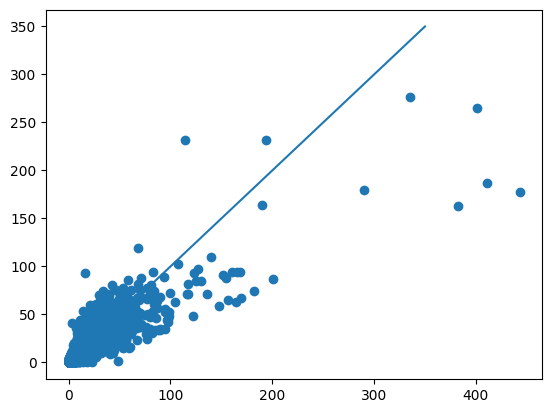

In [88]:
plt.scatter(x=df["nightlight_prev"],y=df["mean"])
plt.plot([0,350],[0,350])
plt.show()

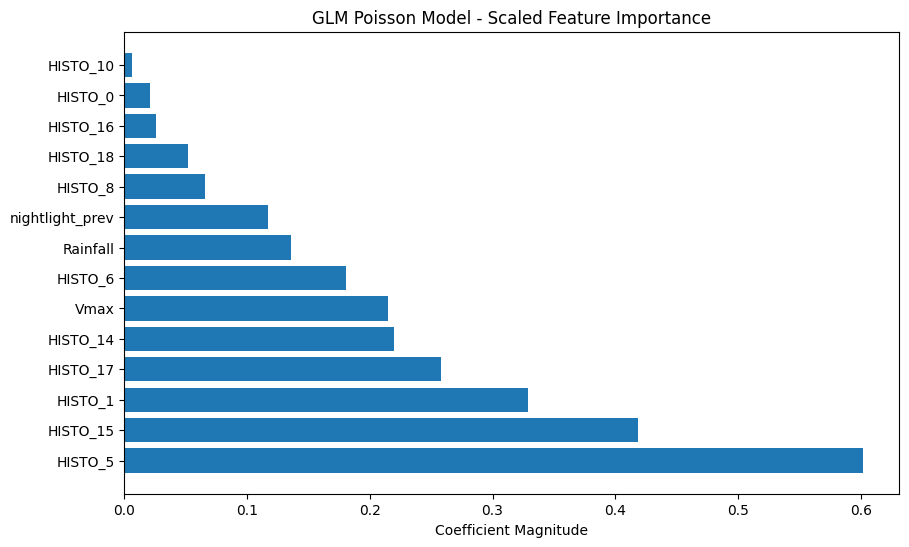

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Assuming you have your data in a pandas DataFrame called 'data'
# X should contain the features used in your model
X = df[independent_vars]
y = df[target]

# Scale the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit a GLM Poisson model on the scaled data
glm_model = sm.GLM(y, sm.add_constant(X_scaled), family=sm.families.Poisson()).fit()

# Get the absolute values of the coefficients
coef_abs = np.abs(glm_model.params[1:])

# Sort the coefficients in descending order
sorted_indices = np.argsort(coef_abs)[::-1]
sorted_coef_abs = coef_abs[sorted_indices]

# Get the corresponding feature names
sorted_feature_names = X.columns[sorted_indices]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_coef_abs)), sorted_coef_abs, align='center')
plt.yticks(range(len(sorted_coef_abs)), sorted_feature_names)
plt.xlabel('Coefficient Magnitude')
plt.title('GLM Poisson Model - Scaled Feature Importance')
plt.show()

### Recovery

In [118]:
day_01 = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Nightlights_Monthly/Zonal_Day_01.csv")
day_01 = day_01[["id","_mean"]]

In [119]:
day_4_6.head()

,id,mean
98,99,1.400000
99,100,1.400000
100,101,0.900000
101,102,5.401564
102,103,8.231423


In [120]:
df2 = day_01.merge(day_4_6,on="id",how="inner")
df2.head()

,id,_mean,mean
0,99,0.800000,1.400000
1,100,0.843006,1.400000
2,101,0.900000,0.900000
3,102,1.244677,5.401564
4,103,1.050000,8.231423


In [121]:
df2.shape

(30346, 3)

In [128]:
df2["outage"] = (df2["_mean"] - df2["mean"])/df2["_mean"]*100
df2.head()
df2 = df2[["id","outage"]]
df2.head()

,id,outage
7,633,10.944658
8,634,10.874580
9,635,75.024560
11,637,8.695652
12,638,45.972662


In [123]:
df2.shape

(30346, 4)

In [124]:
df2 = df2[df2["outage"]>0]
df2.shape

(17369, 4)

In [127]:
#merge tif files for nightlights 4-5-6
day_07 = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Nightlights/Isaias/Zonal_Day_07.csv")
day_08 = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Nightlights/Isaias/Zonal_Day_08.csv")
day_09 = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Nightlights/Isaias/Zonal_Day_09.csv")

# Merge the dataframes on the 'id' column
day_7_9 = pd.merge(day_07, day_08, on='id')
day_7_9 = pd.merge(day_7_9, day_09, on='id')

# Calculate the maximum mean value for each id
day_7_9['max_mean'] = day_7_9[['_mean_x', '_mean_y', '_mean']].max(axis=1)

# Drop the individual 'mean' columns
day_7_9 = day_7_9.drop(['_mean_x', '_mean_y', '_mean'], axis=1)

# Rename the 'max_mean' column to 'mean'
day_7_9 = day_7_9.rename(columns={'max_mean': 'phase2'})
day_7_9 = day_7_9[["id","phase2"]]

day_7_9.head()

,id,phase2
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [129]:
regression_df = landcover_zonal.merge(wind,how="left", left_on="id",right_on="ID").fillna(0)
regression_df = regression_df.merge(df2,how="inner",on="id")
regression_df = regression_df.merge(day_7_9,how="inner",on="id")
regression_df = regression_df.merge(night_month,how="inner",on="id")
regression_df = regression_df.merge(rainfall,how="inner",on="id")
regression_df.head()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA,ID,Vmax,outage,phase2,nightlight_prev,Center_Latitude,Center_Longitude,Rainfall
0,633,2054840,-130250,2055340,-130750,0.0,0.0,8.203125,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,23.437500,68.359375,633.0,35.738656,10.944658,1.200000,0.853225,40.999349,-75.118316,43.50561
1,634,2054840,-130750,2055340,-131250,0.0,0.0,58.088235,8.823529,0.0,0.0,0.0,0.0,0.0,11.764706,17.279412,4.044118,634.0,35.740453,10.874580,0.750000,0.600000,40.995100,-75.120032,43.50561
2,635,2054840,-131250,2055340,-131750,0.0,0.0,92.647059,7.352941,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,635.0,35.834563,75.024560,0.768198,0.760320,40.990850,-75.121747,43.50561
3,637,2054840,-132250,2055340,-132750,0.0,0.0,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,637.0,35.838205,8.695652,1.050000,1.050000,40.982351,-75.125176,43.50561
4,638,2054840,-132750,2055340,-133250,0.0,0.0,91.176471,0.000000,0.0,0.0,0.0,0.0,0.0,8.823529,0.000000,0.000000,638.0,35.840040,45.972662,1.296287,1.347842,40.978101,-75.126890,43.50561


In [130]:
regression_df = regression_df.dropna(subset=['nightlight_prev'])
regression_df.shape

(17369, 25)

In [131]:
regression_df.columns

Index(['id', 'left', 'top', 'right', 'bottom', 'HISTO_0', 'HISTO_1', 'HISTO_5',
       'HISTO_6', 'HISTO_8', 'HISTO_10', 'HISTO_14', 'HISTO_15', 'HISTO_16',
       'HISTO_17', 'HISTO_18', 'HISTO_NODATA', 'ID', 'Vmax', 'outage',
       'phase2', 'nightlight_prev', 'Center_Latitude', 'Center_Longitude',
       'Rainfall'],
      dtype='object')

In [132]:
regression_df = regression_df.drop(['id', 'left', 'top', 'right', 'bottom','ID',"Center_Latitude",
                                    "Center_Longitude"], axis=1)
regression_df.shape

(17369, 17)

In [133]:
regression_df = regression_df[regression_df["HISTO_17"]>0]
regression_df.shape

(12243, 17)

In [135]:
regression_df = regression_df.dropna(subset=['phase2'])
regression_df.shape

(12036, 17)

In [137]:
df = regression_df.copy()

df = df.drop("HISTO_NODATA", axis=1)

# Separate independent and dependent variables
X = df.drop('phase2', axis=1)  # Independent variables
y = df['phase2']  # Dependent variable

# Standardize independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and fit the regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Print the model coefficients
print("Model Coefficients:")
for feature, coef in zip(X.columns, reg_model.coef_):
    print(feature, ":", coef)

# Predict on the test set
y_pred = reg_model.predict(X_test)

# Calculate R2 score on the test set
r2 = r2_score(y_test, y_pred)

# Print the R2 score
print("R2 score on the test set:", r2)

Model Coefficients:
HISTO_0 : -0.007515994776895166
HISTO_1 : -0.13478056783169357
HISTO_5 : -0.18861922736961678
HISTO_6 : -0.1359679141295948
HISTO_8 : -0.046115635851143436
HISTO_10 : -0.01296777560932677
HISTO_14 : -0.14885244747796894
HISTO_15 : -0.19158734113200113
HISTO_16 : -0.06325606578997597
HISTO_17 : -0.26658398470793243
HISTO_18 : -0.010962904639062396
Vmax : 0.21219472863273714
outage : 0.0003456781210194326
nightlight_prev : 9.014479246119022
Rainfall : -0.023651770727862287
R2 score on the test set: 0.9231610592673607
